In [5]:
# import the libraries
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object

In [3]:
# function to get the model's ground truth and predicted labels
def get_labels(dataset, model):
    y_labels = []
    for _, label in tqdm(dataset.unbatch()):
        y_labels.append(label)

    y_preds = model.predict(dataset, verbose=1)
    return y_labels, y_preds

In [4]:
# create a function to plot evaluation curves
def plot_evaluation_curves(history, restored_weight_epoch=None, annotate_loc=None):

    epochs = range(len(history.history['loss']))
    val_loss, val_accuracy = history.history["val_loss"], history.history["val_accuracy"]
    train_loss, train_accuracy = history.history["loss"], history.history["accuracy"]

    # plot loss curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend();
    if restored_weight_epoch:
      plt.axvline(restored_weight_epoch-1, color="red", linestyle="--")
    if annotate_loc:  
      plt.annotate("Restored Weights", xy=(restored_weight_epoch-1, 0.05), xytext=annoatate_loc,
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

    # plot accuracy curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    if restored_weight_epoch:
      plt.axvline(restored_weight_epoch-1, color="red", linestyle="--", label="Restored Accuracy")
    if annotate_loc:
      plt.annotate("Restored Weights", xy=(restored_weight_epoch-1, 0.94), xytext=(0.5, 0.93),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

In [5]:
# explore the train data
def explore_data(train_data,class_names,n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break



In [ ]:

IMG_SIZE = (64, 64)
EPOCHS = 20

# Thiết lập callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # Giám sát loss trên tập validation
    factor=0.2,
    patience=1,
    verbose=1,
    min_lr=1e-7
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

Found 60000 files belonging to 2 classes.
Using 48000 files for training.
Found 60000 files belonging to 2 classes.
Using 12000 files for validation.
Found 30000 files belonging to 2 classes.
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.8111 - loss: 1.4111 - val_accuracy: 0.8768 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8688 - loss: 0.3756 - val_accuracy: 0.8907 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.8825 - loss: 0.3204 - val_accuracy: 0.8953 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 4/20
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8883 - loss: 0.3002
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8883 - loss: 0.3002 - val_accuracy: 0.8880 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━

30000it [00:45, 659.64it/s]


235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.72      0.75      0.74      6000
           1       0.94      0.93      0.93     24000

    accuracy                           0.89     30000
   macro avg       0.83      0.84      0.83     30000
weighted avg       0.89      0.89      0.89     30000



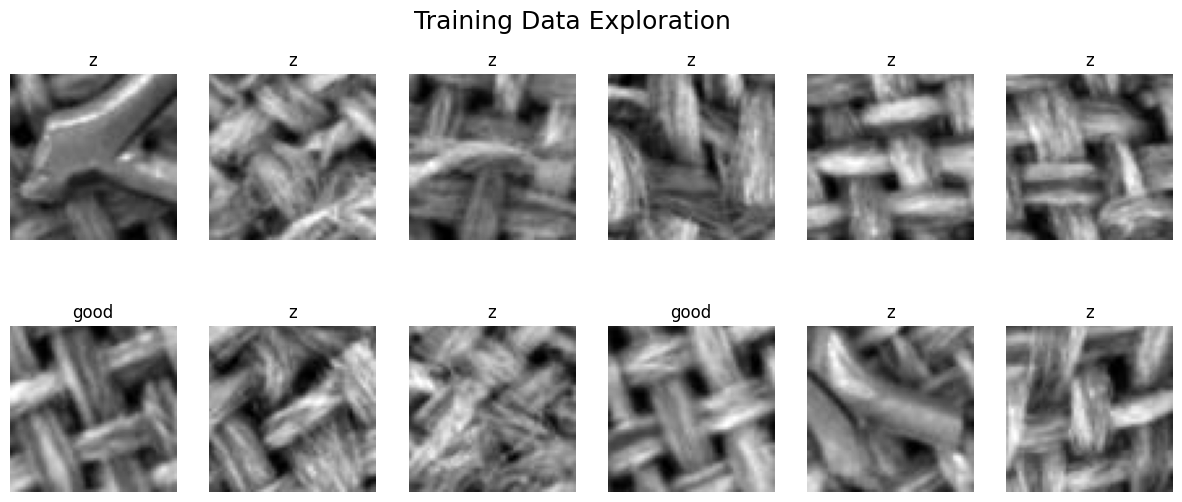

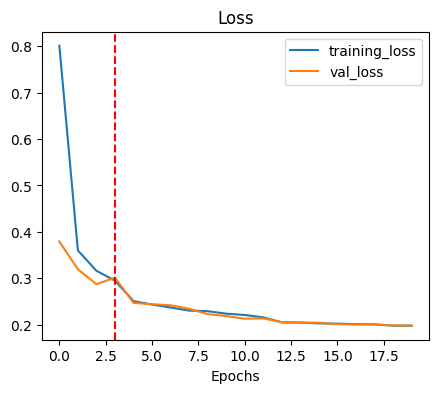

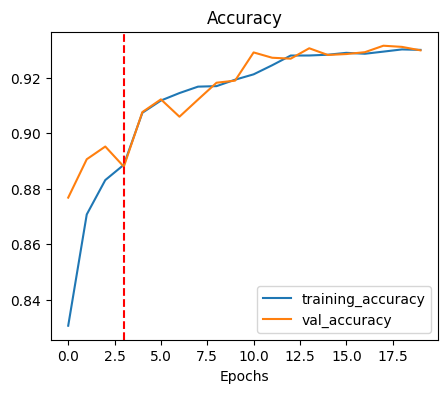

In [7]:

# Tạo pipeline cho dữ liệu training với validation_split
train_good = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/phan-loai-vai-good/Good/train",  # Thư mục gốc chứa các lớp con
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=64,
    validation_split=0.2, # Dùng 20% dữ liệu cho validation
    subset="training",
    seed=123  # Giúp việc chia dữ liệu nhất quán
)
class_name_good = train_good.class_names

explore_data(train_data=train_good,class_names=class_name_good,n_rows=2, n_cols=6, figsize=(15, 6))

val_dataset_good= tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/phan-loai-vai-good/Good/train",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=64,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Nếu bạn có một bộ dữ liệu test riêng:
test_dataset_good = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/phan-loai-vai-good/Good/test",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=128,
    shuffle=True
)
test_dataset_good= test_dataset_good.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

# Xây dựng mô hình
model_good = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), name="input_layer"),
    tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
    tf.keras.layers.Conv2D(16, 2, activation="relu"),
    tf.keras.layers.Conv2D(32, 2, activation="relu"),
    tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
])



# Compile mô hình
model_good.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Huấn luyện mô hình
history_good = model_good.fit(
    train_good,
    validation_data=val_dataset_good,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)
model_good.save("/kaggle/working/tuan_tu_model_good.h5")
plot_evaluation_curves(history_good, 4)
y_labels_good, y_preds_good = get_labels(test_dataset_good, model_good)

# get the classification report
print("############### Classification Report ###############\n\n")
print(classification_report(y_labels_good, np.round(y_preds_good)))

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load model đã lưu
model_good = tf.keras.models.load_model("/kaggle/working/tuan_tu_model_good.h5")

# Ví dụ 1: Dự đoán trên bộ dữ liệu test đã tạo sẵn
predictions = model_good.predict(test_dataset_good)
print("Predictions trên test_dataset_good:", predictions)

# Ví dụ 2: Dự đoán trên một ảnh đơn lẻ
# Đường dẫn đến ảnh cần dự đoán (cập nhật đường dẫn cho phù hợp)
img_path = "/kaggle/input/phan-loai-vai-good/Good/test/z/1000_angle100.jpeg"

# Load ảnh với kích thước IMG_SIZE và chế độ grayscale như khi training
img = image.load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

# Dự đoán
pred = model_good.predict(img_array)
print("Prediction cho ảnh:", pred)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Predictions trên test_dataset_good: [[0.9976955 ]
 [0.9999938 ]
 [0.998164  ]
 ...
 [0.99923706]
 [0.99582976]
 [0.26832107]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Prediction cho ảnh: [[0.27202109]]


Found 72000 files belonging to 2 classes.
Using 57600 files for training.
Found 24000 files belonging to 2 classes.
Using 4800 files for validation.
Found 24000 files belonging to 2 classes.
Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6344 - loss: 1.4639 - val_accuracy: 0.8377 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.8234 - loss: 0.4578 - val_accuracy: 0.9227 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.9145 - loss: 0.2671 - val_accuracy: 0.9367 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


24000it [00:27, 888.22it/s]


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.62      0.94      0.74      6000
           1       0.98      0.81      0.88     18000

    accuracy                           0.84     24000
   macro avg       0.80      0.87      0.81     24000
weighted avg       0.89      0.84      0.85     24000



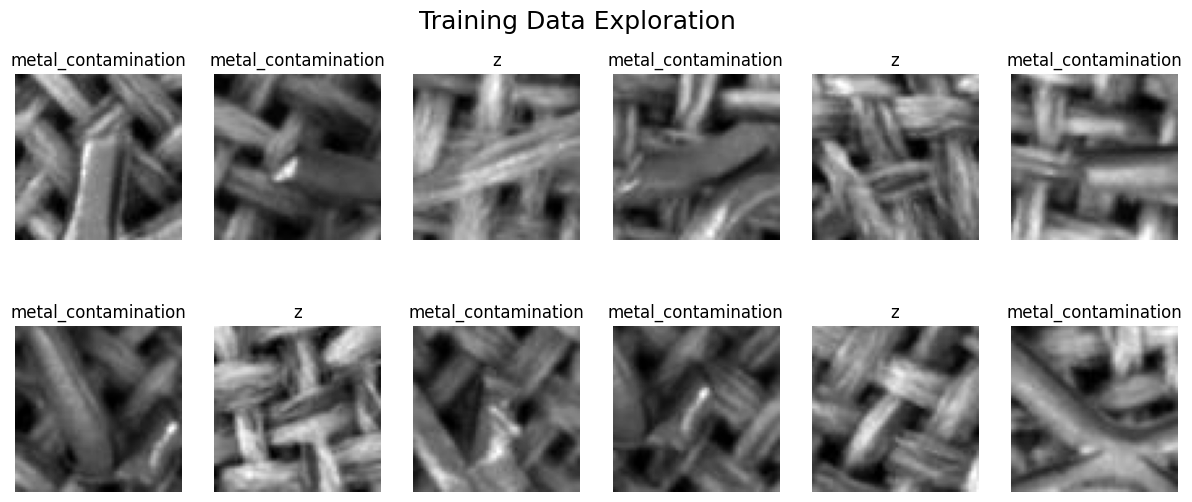

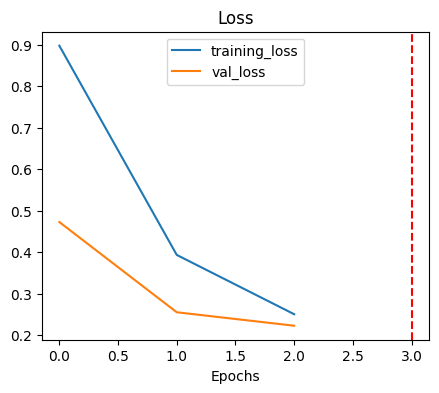

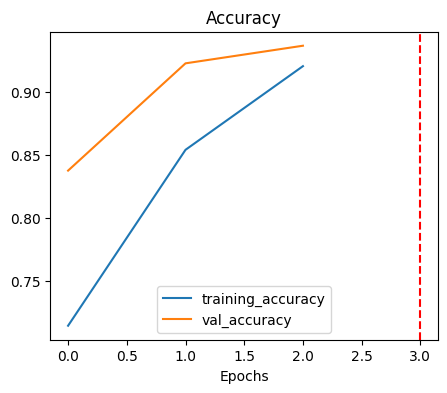

In [9]:

# Tạo pipeline cho dữ liệu training với validation_split
train_metal = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/phan-loai-vai-lan2/train/train/Tuan_Tu/Metal_contamination",  # Thư mục gốc chứa các lớp con
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=64,
    validation_split=0.2,  # Dùng 20% dữ liệu cho validation
    subset="training",
    seed=123  # Giúp việc chia dữ liệu nhất quán
)
class_names_metal = train_metal.class_names

explore_data(train_data=train_metal,class_names=class_names_metal,n_rows=2, n_cols=6, figsize=(15, 6))

val_dataset_metal= tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/phan-loai-vai-lan2/test/test/tuan_tu/metal",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=64,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Nếu bạn có một bộ dữ liệu test riêng:
test_dataset_metal = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/phan-loai-vai-lan2/test/test/tuan_tu/metal",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=128,
    shuffle=True
)
test_dataset_metal= test_dataset_metal.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

# Xây dựng mô hình
model_metal = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), name="input_layer"),
    tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
    tf.keras.layers.Conv2D(16, 2, activation="relu"),
    tf.keras.layers.Conv2D(32, 2, activation="relu"),
    tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
])



# Compile mô hình
model_metal.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Huấn luyện mô hình
history_metal = model_metal.fit(
    train_metal,
    validation_data=val_dataset_metal,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)
model_metal.save("/kaggle/working/tuan_tu_model_metal.h5")
plot_evaluation_curves(history_metal, 4)
y_labels_metal, y_preds_metal = get_labels(test_dataset_metal, model_metal)

# get the classification report
print("############### Classification Report ###############\n\n")
print(classification_report(y_labels_metal, np.round(y_preds_metal)))

In [10]:
import numpy as np

# Load mô hình đã lưu
load_model_metal = tf.keras.models.load_model("/kaggle/working/tuan_tu_model_metal.h5")

# Lấy nhãn thực tế từ tập test
y_label_metal = np.concatenate([y for x, y in test_dataset_metal], axis=0)

# Dự đoán trên tập test
y_pred_probs_metal = load_model_metal.predict(test_dataset_metal)
y_pred_labels_metal = (y_pred_probs_metal > 0.5).astype(int)

# Đếm số lần dự đoán đúng và sai
num_correct = np.sum(y_pred_labels_metal.flatten() == y_label_metal.flatten())
num_total = len(y_label_metal)
num_wrong = num_total - num_correct

# In kết quả
print(f"Số lần dự đoán đúng: {num_correct}/{num_total}")
print(f"Số lần dự đoán sai: {num_wrong}/{num_total}")
print(f"Độ chính xác: {num_correct / num_total:.2%}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Số lần dự đoán đúng: 20128/24000
Số lần dự đoán sai: 3872/24000
Độ chính xác: 83.87%


In [11]:
import cv2
img_path0="/kaggle/input/phan-loai-vai-lan2/test/test/tuan_tu/metal/metal_contamination/18000_angle0.jpeg"
img0 = cv2.imread(img_path0, cv2.IMREAD_GRAYSCALE)
img0 = cv2.resize(img0,IMG_SIZE)
img0 = img0 /255.0
img0 = np.expand_dims(img0, axis = -1)
img0 = np.expand_dims(img0, axis = 0)
pred_img_prob0 = load_model_metal.predict(img0)[0][0]
pred_img_label0 = int(pred_img_prob0>0.5)
# In kết quả
print(f"Nhãn dự đoán(0): {pred_img_label0}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Nhãn dự đoán(0): 0


In [12]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Hàm load hình ảnh từ thư mục
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Đường dẫn gốc chứa dữ liệu train
data_dir = "/kaggle/input/phan-loai-vai-3-train/3_train"
classes = ["cut", "hole", "thread"]

features = []
labels = []

# Lặp qua từng lớp và trích xuất đặc trưng HOG
for cls in classes:
    folder_path = os.path.join(data_dir, cls)
    imgs = load_images_from_folder(folder_path)
    print("dang load anh tai class ",cls)
    for img in imgs:
        # Tính toán đặc trưng HOG, có thể tùy chỉnh các tham số
        feature, hog_image = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        features.append(feature)
        labels.append(cls)

features = np.array(features)
labels = np.array(labels)
print("xong!")
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("train...")
# Sử dụng SVM để phân loại
clf = LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra và in báo cáo đánh giá
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


dang load anh tai class  cut
dang load anh tai class  hole
dang load anh tai class  thread
xong!
train...
              precision    recall  f1-score   support

         cut       0.75      0.74      0.74      2400
        hole       0.73      0.75      0.74      2376
      thread       0.80      0.80      0.80      2424

    accuracy                           0.76      7200
   macro avg       0.76      0.76      0.76      7200
weighted avg       0.76      0.76      0.76      7200



In [13]:
import joblib

# Lưu mô hình đã huấn luyện
model_path = "svm_model_3.pkl"
joblib.dump(clf, model_path)
print(f"Đã lưu mô hình tại {model_path}")


Đã lưu mô hình tại svm_model_3.pkl


In [14]:
# Load mô hình đã lưu
clf_loaded = joblib.load("/kaggle/working/svm_model_3.pkl")

# Hàm để tiền xử lý và trích xuất đặc trưng HOG của một ảnh mới
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Lỗi: Không thể đọc ảnh.")
        return None
    
    # Tính toán đặc trưng HOG
    feature, _ = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )
    
    # Chuyển feature về dạng numpy array
    feature = np.array(feature).reshape(1, -1)  # Reshape về (1, số lượng đặc trưng)
    
    # Dự đoán
    predicted_class = clf_loaded.predict(feature)[0]
    print(f"Dự đoán lớp: {predicted_class}")
    return predicted_class

# Ví dụ: Dự đoán với một ảnh từ bộ test
image_path = "/kaggle/input/phan-loai-vai-3-train/3_train/cut/10020_angle60.jpeg"
predict_image(image_path)


Dự đoán lớp: cut


'cut'

In [ ]:
!zip -r file.zip /kaggle/working
!ls
from IPython.display import FileLink
FileLink(r'file.zip')
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)
zip_dir()